
# Comprehensive Experiment Analysis

The following sections analyze previously saved experiment logs across all Retrieval-Augmented Generation (RAG) architectures. We move from sanity checks to routing diagnostics using elegant Matplotlib/Seaborn visuals.



## 1. Setup and data loading
Load the consolidated CSV (and cross-check with the JSON replica), inspect schema, and engineer helper columns for downstream analysis.


In [96]:
RESULTS_DIR = "../results"

In [97]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid", context="talk")
plt.style.use('seaborn-v0_8-whitegrid')

CSV_RESULTS_PATH = RESULTS_DIR + '/experiment_results.csv'
JSON_RESULTS_PATH = RESULTS_DIR + '/experiment_results.json'

In [98]:

analysis_df = pd.read_csv(CSV_RESULTS_PATH)
analysis_df.head()


,question,architecture,time_ms,tokens,keyword_precision_k,keyword_recall_k,semantic_precision_k,semantic_recall_k,grounding_score,routing_pipeline,routing_profile
0,Which sport has teams of 6 players: football o...,vanilla,5083.0666,1.0,1.0,0.2,0.2,1.0,1.000000,NaN,NaN
1,Which sport has teams of 6 players: football o...,self_reflective,45649.6262,229.0,1.0,0.2,0.6,0.6,0.922705,NaN,NaN
2,Which sport has teams of 6 players: football o...,query_decomposition,40837.2890,32.0,1.0,0.2,0.0,0.0,0.777778,NaN,NaN
3,Which sport has teams of 6 players: football o...,chain_of_verification,138493.2516,76.0,1.0,0.2,0.2,1.0,0.521739,NaN,NaN
4,Which sport has teams of 6 players: football o...,active_retrieval,16393.2133,1.0,1.0,0.2,0.2,1.0,1.000000,NaN,NaN


In [99]:

print("DataFrame info:")
analysis_df.info()
print("Basic stats:")
print("Missing values per column:")
print(analysis_df.isna().sum())
print("Architectures present:")
print(analysis_df['architecture'].unique())
print("Counts per architecture:")
print(analysis_df['architecture'].value_counts())

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   question              24 non-null     object 
 1   architecture          24 non-null     object 
 2   time_ms               24 non-null     float64
 3   tokens                24 non-null     float64
 4   keyword_precision_k   24 non-null     float64
 5   keyword_recall_k      24 non-null     float64
 6   semantic_precision_k  24 non-null     float64
 7   semantic_recall_k     24 non-null     float64
 8   grounding_score       24 non-null     float64
 9   routing_pipeline      3 non-null      object 
 10  routing_profile       3 non-null      object 
dtypes: float64(7), object(4)
memory usage: 2.2+ KB
Basic stats:
Missing values per column:
question                 0
architecture             0
time_ms                  0
tokens                   0
keyword_precision_

In [100]:
display(analysis_df.describe(include='all'))

,question,architecture,time_ms,tokens,keyword_precision_k,keyword_recall_k,semantic_precision_k,semantic_recall_k,grounding_score,routing_pipeline,routing_profile
count,24,24,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000,24.000000,3,3
unique,3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
top,Which sport has teams of 6 players: football o...,vanilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vanilla,balanced_openai
freq,8,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
mean,NaN,NaN,27344.029829,31.958333,0.883333,0.232228,0.22500,0.556250,0.726361,NaN,NaN
std,NaN,NaN,27108.992270,46.808100,0.185722,0.116796,0.22312,0.488857,0.216710,NaN,NaN
min,NaN,NaN,3867.004600,1.000000,0.600000,0.103448,0.00000,0.000000,0.166667,NaN,NaN
25%,NaN,NaN,13840.746400,11.750000,0.600000,0.103448,0.00000,0.000000,0.575000,NaN,NaN
50%,NaN,NaN,25108.991650,16.000000,1.000000,0.200000,0.20000,0.875000,0.774597,NaN,NaN
75%,NaN,NaN,34063.150950,32.250000,1.000000,0.384615,0.40000,1.000000,0.894138,NaN,NaN


In [101]:

def _harmonic_mean(precision: pd.Series, recall: pd.Series) -> pd.Series:
    numerator = 2 * precision * recall
    denominator = precision + recall
    f1 = np.where((precision > 0) & (recall > 0), numerator / denominator, 0.0)
    return f1

analysis_df['keyword_f1_k'] = _harmonic_mean(
    analysis_df['keyword_precision_k'], analysis_df['keyword_recall_k']
)
analysis_df['semantic_f1_k'] = _harmonic_mean(
    analysis_df['semantic_precision_k'], analysis_df['semantic_recall_k']
)
analysis_df['question_id'] = analysis_df['question'].factorize()[0]
analysis_df['semantic_per_log_time'] = analysis_df['semantic_f1_k'] / np.log1p(analysis_df['time_ms'].clip(lower=1e-3))
analysis_df.head()


,question,architecture,time_ms,tokens,keyword_precision_k,keyword_recall_k,semantic_precision_k,semantic_recall_k,grounding_score,routing_pipeline,routing_profile,keyword_f1_k,semantic_f1_k,question_id,semantic_per_log_time
0,Which sport has teams of 6 players: football o...,vanilla,5083.0666,1.0,1.0,0.2,0.2,1.0,1.000000,NaN,NaN,0.333333,0.333333,0,0.039060
1,Which sport has teams of 6 players: football o...,self_reflective,45649.6262,229.0,1.0,0.2,0.6,0.6,0.922705,NaN,NaN,0.333333,0.600000,0,0.055924
2,Which sport has teams of 6 players: football o...,query_decomposition,40837.2890,32.0,1.0,0.2,0.0,0.0,0.777778,NaN,NaN,0.333333,0.000000,0,0.000000
3,Which sport has teams of 6 players: football o...,chain_of_verification,138493.2516,76.0,1.0,0.2,0.2,1.0,0.521739,NaN,NaN,0.333333,0.333333,0,0.028157
4,Which sport has teams of 6 players: football o...,active_retrieval,16393.2133,1.0,1.0,0.2,0.2,1.0,1.000000,NaN,NaN,0.333333,0.333333,0,0.034348



## 2. Basic descriptive statistics
Summaries per architecture plus coverage statistics help benchmark the evaluation dataset.


In [102]:

agg_spec = {
    'time_ms': ['mean', 'median', 'std'],
    'tokens': ['mean', 'median', 'std'],
    'keyword_precision_k': ['mean', 'median', 'std'],
    'keyword_recall_k': ['mean', 'median', 'std'],
    'keyword_f1_k': ['mean', 'median', 'std'],
    'semantic_precision_k': ['mean', 'median', 'std'],
    'semantic_recall_k': ['mean', 'median', 'std'],
    'semantic_f1_k': ['mean', 'median', 'std'],
    'grounding_score': ['mean'],
}
arch_summary = analysis_df.groupby('architecture').agg(agg_spec)
arch_summary.columns = [f"{metric}_{stat}" for metric, stat in arch_summary.columns]
arch_summary = arch_summary.round(4)

total_questions = analysis_df['question'].nunique()
questions_per_arch = analysis_df.groupby('architecture')['question'].nunique().rename('question_coverage')

print(f"Total unique questions: {total_questions}")
display(questions_per_arch)
display(arch_summary)

semantic_rank = arch_summary.sort_values('semantic_f1_k_mean', ascending=False)
latency_rank = arch_summary.sort_values('time_ms_mean')
print("Semantic F1 ranking (desc):")
print(semantic_rank['semantic_f1_k_mean'])
print("Latency ranking (asc):")
print(latency_rank['time_ms_mean'])


Total unique questions: 3


architecture
active_retrieval         3
chain_of_verification    3
madam_rag                3
marag                    3
query_decomposition      3
routing                  3
self_reflective          3
vanilla                  3
Name: question_coverage, dtype: int64

,time_ms_mean,time_ms_median,time_ms_std,tokens_mean,tokens_median,tokens_std,keyword_precision_k_mean,keyword_precision_k_median,keyword_precision_k_std,keyword_recall_k_mean,...,semantic_precision_k_mean,semantic_precision_k_median,semantic_precision_k_std,semantic_recall_k_mean,semantic_recall_k_median,semantic_recall_k_std,semantic_f1_k_mean,semantic_f1_k_median,semantic_f1_k_std,grounding_score_mean
architecture,,,,,,,,,,,,,,,,,,,,,
active_retrieval,17829.0648,18498.5386,1244.4275,8.0000,11.0,6.0828,0.8667,1.0,0.2309,0.2294,...,0.0667,0.0,0.1155,0.3333,0.00,0.5774,0.1111,0.0000,0.1925,0.7635
chain_of_verification,73046.9981,41878.7794,56699.4428,52.0000,57.0,26.8514,0.8667,1.0,0.2309,0.2294,...,0.2000,0.2,0.2000,0.6667,1.00,0.5774,0.3016,0.3333,0.2870,0.5275
madam_rag,28754.1407,30196.9782,3116.3453,10.3333,11.0,5.0332,0.8667,1.0,0.2309,0.2294,...,0.1333,0.0,0.2309,0.3333,0.00,0.5774,0.1905,0.0000,0.3299,0.4306
marag,29933.0056,28596.2379,5500.5133,19.6667,19.0,5.0332,0.8667,1.0,0.2309,0.2294,...,0.1333,0.0,0.2309,0.3333,0.00,0.5774,0.1905,0.0000,0.3299,0.8004
query_decomposition,24832.8500,16990.4566,13861.1722,31.3333,32.0,2.0817,1.0000,1.0,0.0000,0.2523,...,0.3333,0.4,0.3055,0.6667,1.00,0.5774,0.4405,0.5714,0.3918,0.7440
routing,5110.5234,4619.7037,930.2093,9.6667,12.0,7.7675,0.8667,1.0,0.2309,0.2294,...,0.2000,0.2,0.2000,0.6667,1.00,0.5774,0.3016,0.3333,0.2870,0.8571
self_reflective,34704.7971,33424.6356,10364.2148,115.0000,75.0,100.1798,0.8667,1.0,0.2309,0.2294,...,0.5333,0.6,0.1155,0.7833,0.75,0.2021,0.6127,0.6000,0.0489,0.8343
vanilla,4540.8588,4672.5053,618.6273,9.6667,12.0,7.7675,0.8667,1.0,0.2309,0.2294,...,0.2000,0.2,0.2000,0.6667,1.00,0.5774,0.3016,0.3333,0.2870,0.8535


Semantic F1 ranking (desc):
architecture
self_reflective          0.6127
query_decomposition      0.4405
chain_of_verification    0.3016
routing                  0.3016
vanilla                  0.3016
madam_rag                0.1905
marag                    0.1905
active_retrieval         0.1111
Name: semantic_f1_k_mean, dtype: float64
Latency ranking (asc):
architecture
vanilla                   4540.8588
routing                   5110.5234
active_retrieval         17829.0648
query_decomposition      24832.8500
madam_rag                28754.1407
marag                    29933.0056
self_reflective          34704.7971
chain_of_verification    73046.9981
Name: time_ms_mean, dtype: float64



## 3. Basic performance visualizations
Compare runtime, quality, tokens, and score distributions across architectures.


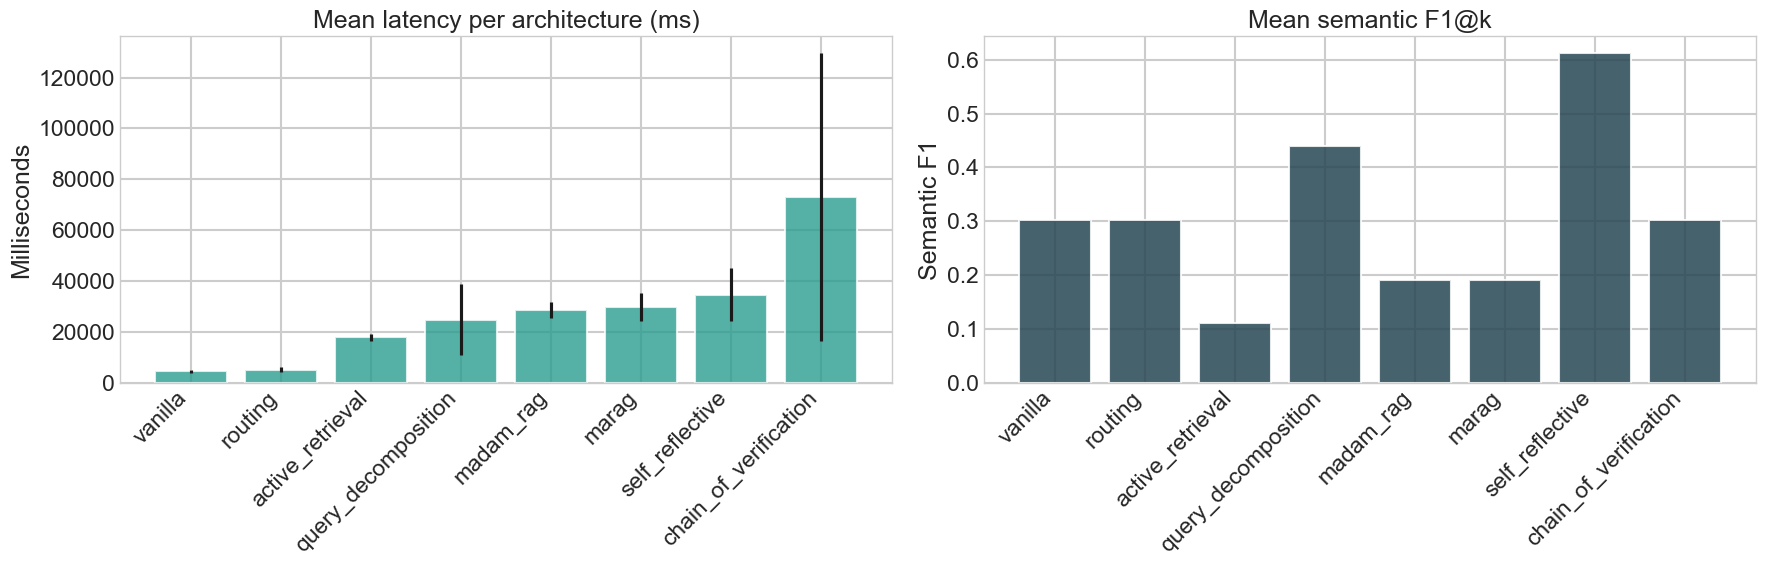

In [103]:
plot_order = arch_summary.sort_values('time_ms_mean').index.tolist()
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

x = np.arange(len(plot_order))

time_means = arch_summary.loc[plot_order, 'time_ms_mean']
time_stds = arch_summary.loc[plot_order, 'time_ms_std']
axes[0].bar(x, time_means, yerr=time_stds, color='#2a9d8f', alpha=0.8)
axes[0].set_title('Mean latency per architecture (ms)')
axes[0].set_ylabel('Milliseconds')
axes[0].set_xticks(x)
axes[0].set_xticklabels(plot_order, rotation=45, ha='right')

semantic_means = arch_summary.loc[plot_order, 'semantic_f1_k_mean']
axes[1].bar(x, semantic_means, color='#264653', alpha=0.85)
axes[1].set_title('Mean semantic F1@k')
axes[1].set_ylabel('Semantic F1')
axes[1].set_xticks(x)
axes[1].set_xticklabels(plot_order, rotation=45, ha='right')

plt.tight_layout()

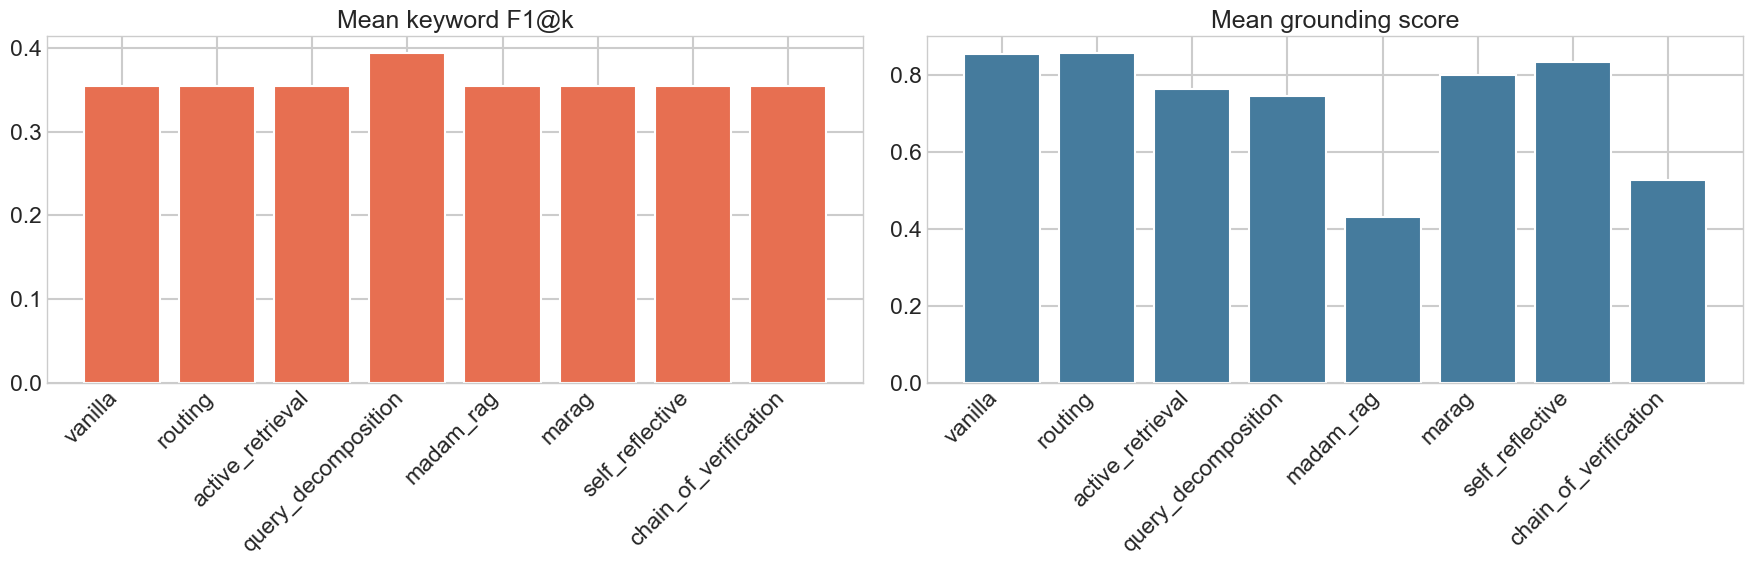

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
x = np.arange(len(plot_order))

keyword_means = arch_summary.loc[plot_order, 'keyword_f1_k_mean']
axes[0].bar(x, keyword_means, color='#e76f51')
axes[0].set_title('Mean keyword F1@k')
axes[0].set_xticks(x)
axes[0].set_xticklabels(plot_order, rotation=45, ha='right')

if analysis_df['grounding_score'].notna().any():
    ground_means = arch_summary.loc[plot_order, 'grounding_score_mean']
    axes[1].bar(x, ground_means, color='#457b9d')
    axes[1].set_title('Mean grounding score')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(plot_order, rotation=45, ha='right')
else:
    axes[1].set_visible(False)

plt.tight_layout()


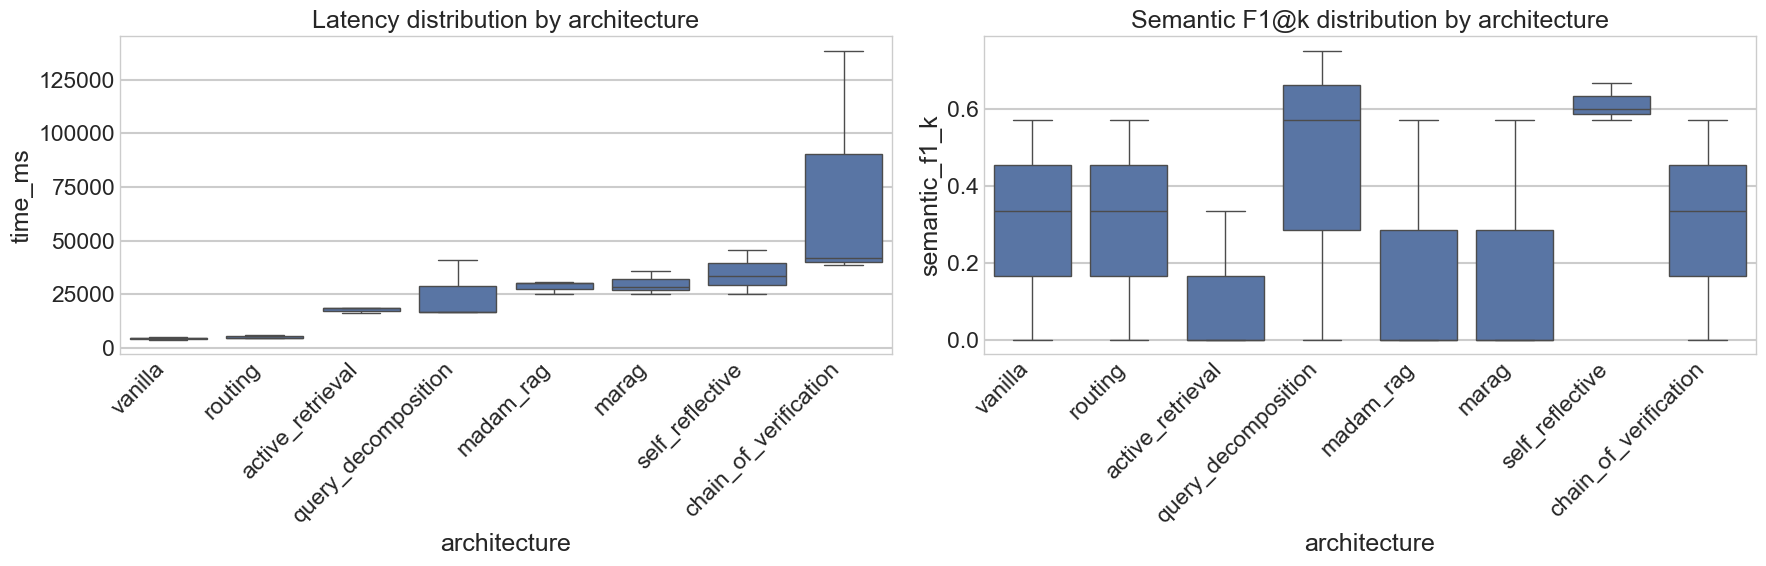

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(data=analysis_df, x='architecture', y='time_ms', ax=axes[0], order=plot_order)
axes[0].set_title('Latency distribution by architecture')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
sns.boxplot(data=analysis_df, x='architecture', y='semantic_f1_k', ax=axes[1], order=plot_order)
axes[1].set_title('Semantic F1@k distribution by architecture')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()


Most token-heavy architecture: self_reflective (115.0 tokens)
Most token-efficient architecture: active_retrieval (8.0 tokens)


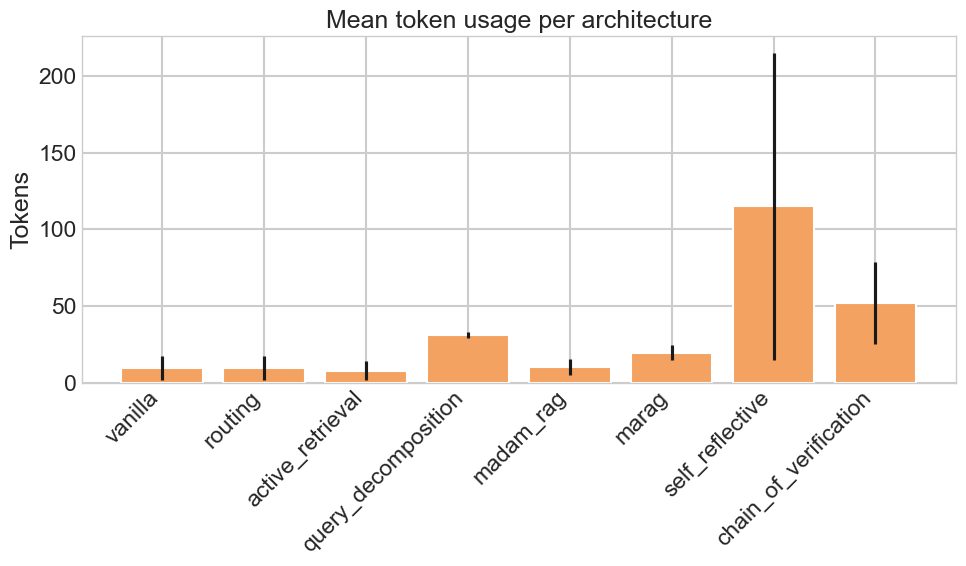

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))
token_stats = arch_summary.loc[plot_order, ['tokens_mean', 'tokens_std']]
x = np.arange(len(plot_order))
ax.bar(x, token_stats['tokens_mean'], yerr=token_stats['tokens_std'], color='#f4a261')
ax.set_title('Mean token usage per architecture')
ax.set_ylabel('Tokens')
ax.set_xticks(x)
ax.set_xticklabels(plot_order, rotation=45, ha='right')
plt.tight_layout()

heavy_arch = token_stats['tokens_mean'].idxmax()
light_arch = token_stats['tokens_mean'].idxmin()
print(f"Most token-heavy architecture: {heavy_arch} ({token_stats.loc[heavy_arch, 'tokens_mean']:.1f} tokens)")
print(f"Most token-efficient architecture: {light_arch} ({token_stats.loc[light_arch, 'tokens_mean']:.1f} tokens)")



## 4. Per-question architecture comparisons
Switch to per-question views for apples-to-apples comparisons.


Sample question: Which sport has teams of 6 players: football or volleyball?


,architecture,time_ms,semantic_f1_k,keyword_f1_k,tokens
0,vanilla,5083.0666,0.333333,0.333333,1.0
1,self_reflective,45649.6262,0.600000,0.333333,229.0
2,query_decomposition,40837.2890,0.000000,0.333333,32.0
3,chain_of_verification,138493.2516,0.333333,0.333333,76.0
4,active_retrieval,16393.2133,0.333333,0.333333,1.0
5,marag,35978.6970,0.000000,0.333333,19.0
6,madam_rag,30887.5902,0.000000,0.333333,5.0
7,routing,4528.5209,0.333333,0.333333,1.0


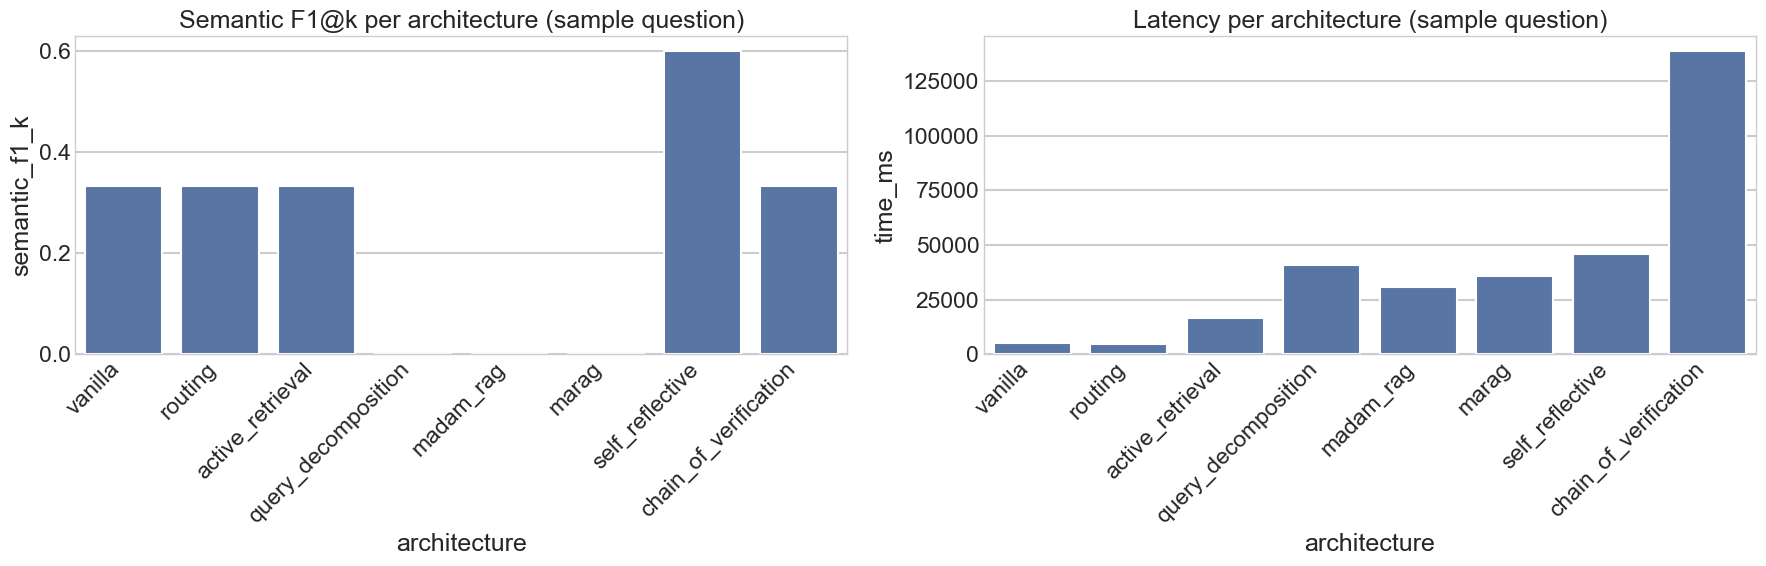

In [107]:
sample_question = analysis_df['question'].iloc[0]
sample_df = analysis_df[analysis_df['question'] == sample_question]
print(f"Sample question: {sample_question}")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=sample_df, x='architecture', y='semantic_f1_k', order=plot_order, ax=axes[0])
axes[0].set_title('Semantic F1@k per architecture (sample question)')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
sns.barplot(data=sample_df, x='architecture', y='time_ms', order=plot_order, ax=axes[1])
axes[1].set_title('Latency per architecture (sample question)')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
display(sample_df[['architecture', 'time_ms', 'semantic_f1_k', 'keyword_f1_k', 'tokens']])


Trade-off ranking (semantic F1 / log latency):
architecture
self_reflective          0.058780
query_decomposition      0.045259
routing                  0.035771
vanilla                  0.035562
chain_of_verification    0.027283
marag                    0.018793
madam_rag                0.018465
active_retrieval         0.011449
Name: semantic_per_log_time, dtype: float64


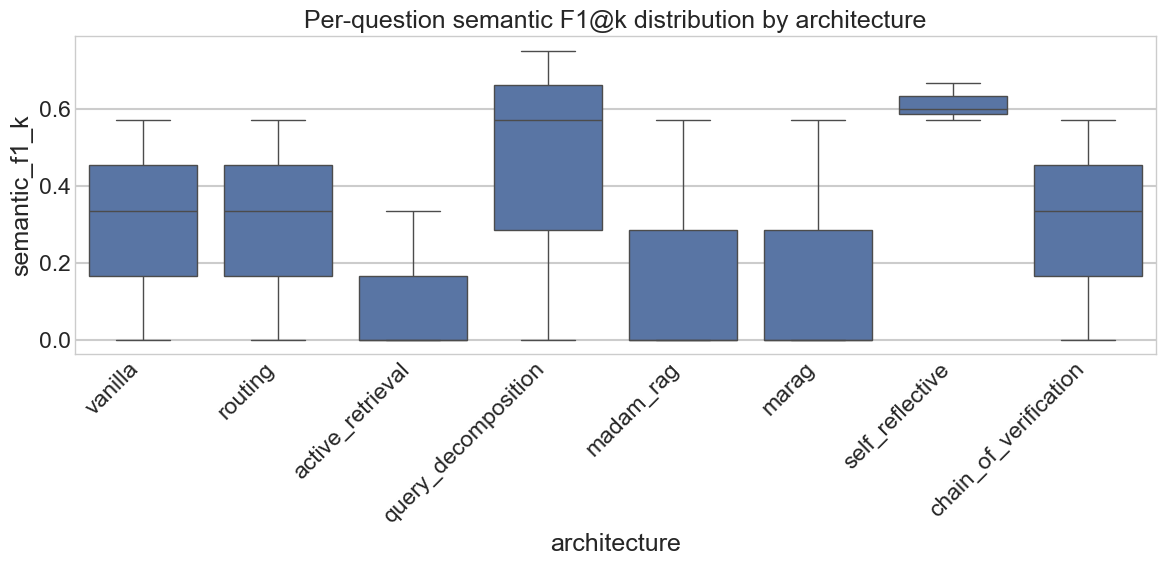

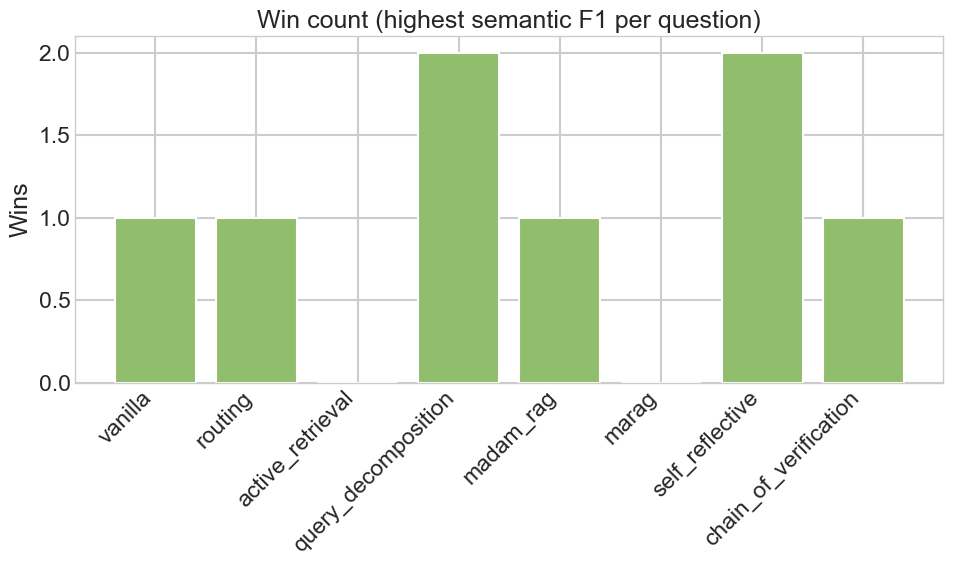

In [108]:
per_question_semantic = (
    analysis_df.groupby(['architecture', 'question_id'])['semantic_f1_k']
    .mean()
    .reset_index()
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=per_question_semantic, x='architecture', y='semantic_f1_k', order=plot_order, ax=ax)
ax.set_title('Per-question semantic F1@k distribution by architecture')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

win_records = []
for qid, group in analysis_df.groupby('question_id'):
    max_val = group['semantic_f1_k'].max()
    winners = group[group['semantic_f1_k'] == max_val]['architecture'].unique()
    for winner in winners:
        win_records.append({'question_id': qid, 'architecture': winner})
win_df = pd.DataFrame(win_records)
win_counts = win_df['architecture'].value_counts().reindex(plot_order, fill_value=0)
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(win_counts))
ax.bar(x, win_counts.values, color='#90be6d')
ax.set_title('Win count (highest semantic F1 per question)')
ax.set_ylabel('Wins')
ax.set_xticks(x)
ax.set_xticklabels(win_counts.index, rotation=45, ha='right')
plt.tight_layout()

tradeoff_scores = (
    analysis_df.groupby(['architecture', 'question_id'])['semantic_per_log_time']
    .mean()
    .reset_index()
)
tradeoff_summary = tradeoff_scores.groupby('architecture')['semantic_per_log_time'].mean().sort_values(ascending=False)
print("Trade-off ranking (semantic F1 / log latency):")
print(tradeoff_summary)



## 5. Latency vs quality trade-offs
Scatter plots show Pareto behavior at both run-level and architecture-level granularity.


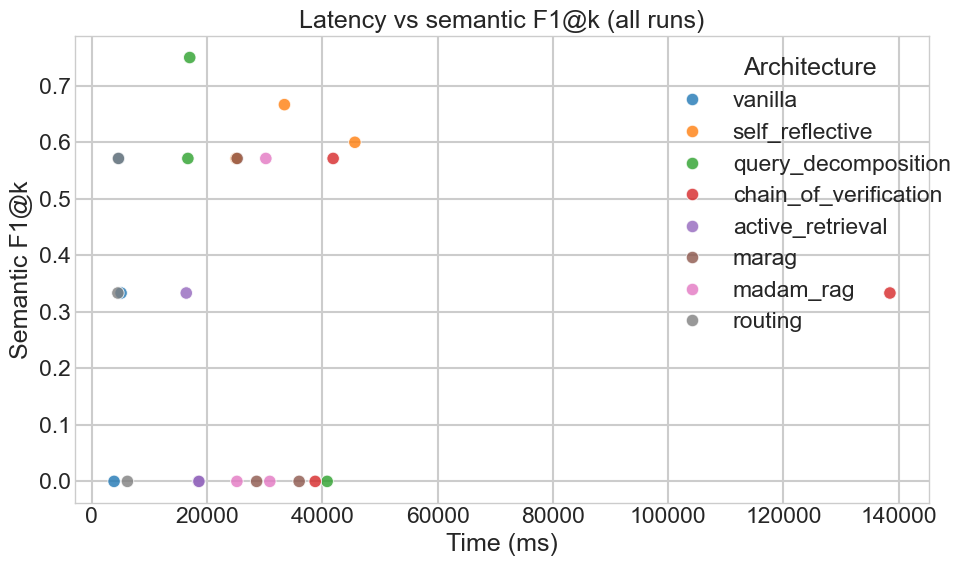

In [115]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=analysis_df,
    x='time_ms',
    y='semantic_f1_k',
    hue='architecture',
    palette='tab10',
    alpha=0.8,
    ax=ax,
)
ax.set_title('Latency vs semantic F1@k (all runs)')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Semantic F1@k')
plt.legend(title='Architecture', bbox_to_anchor=(1.05, 1), loc='upper right')
plt.tight_layout()


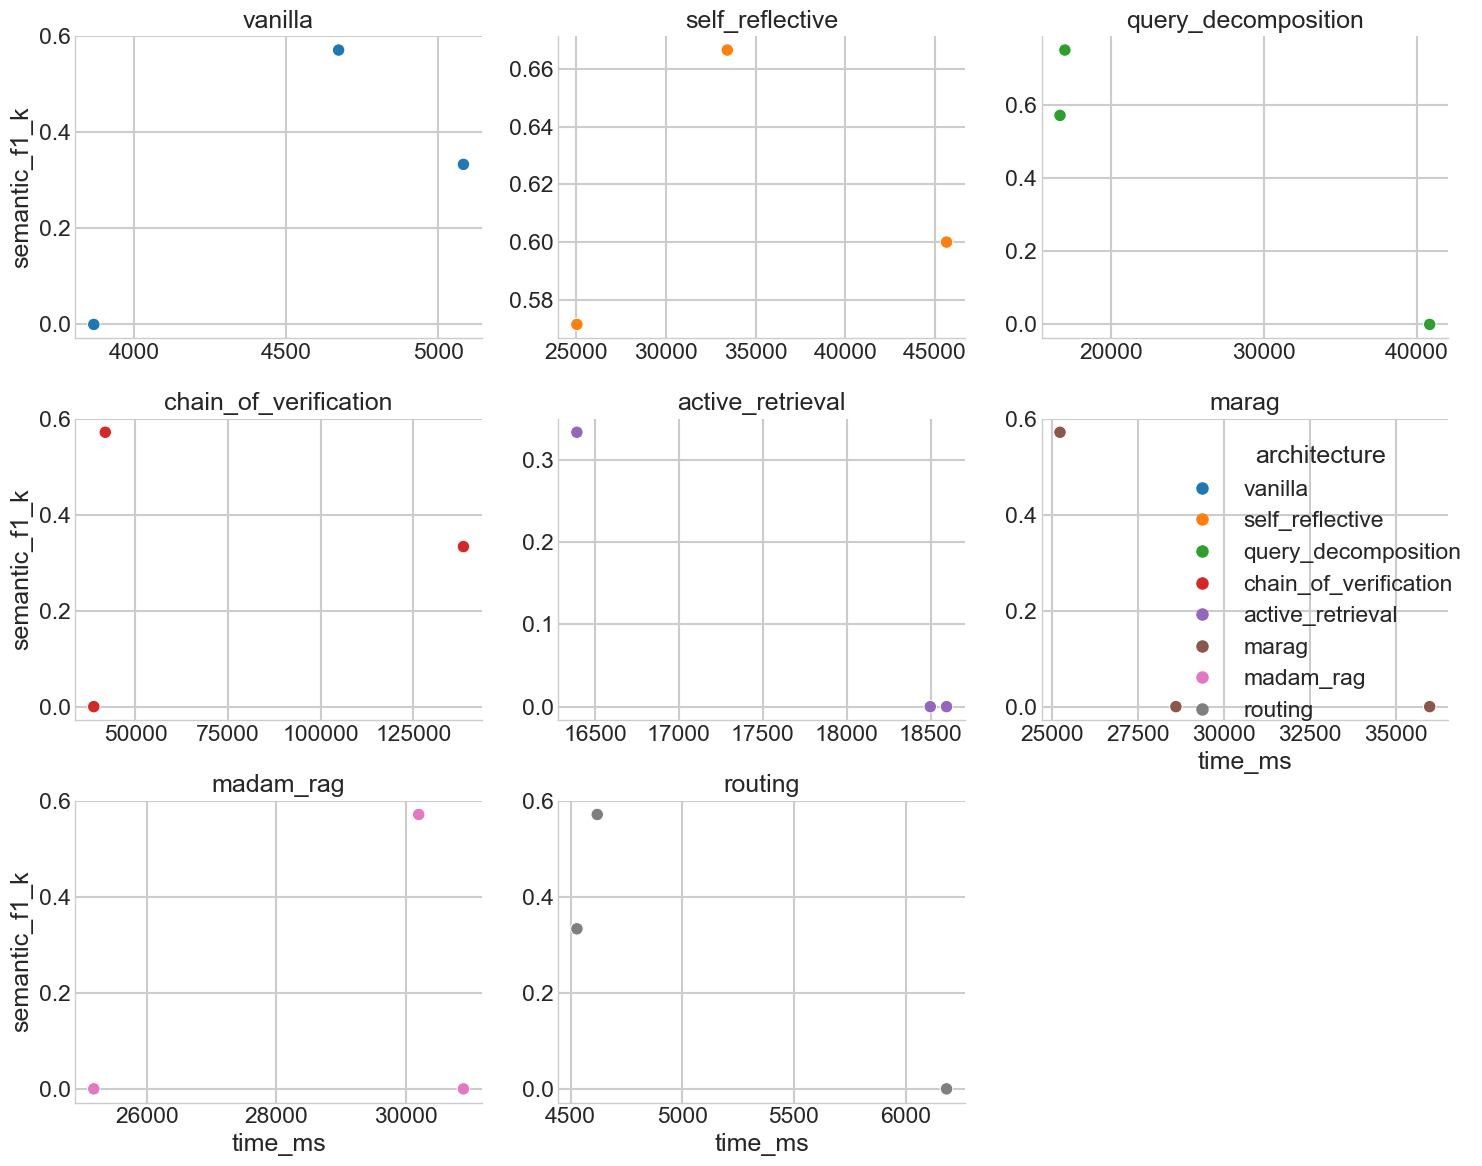

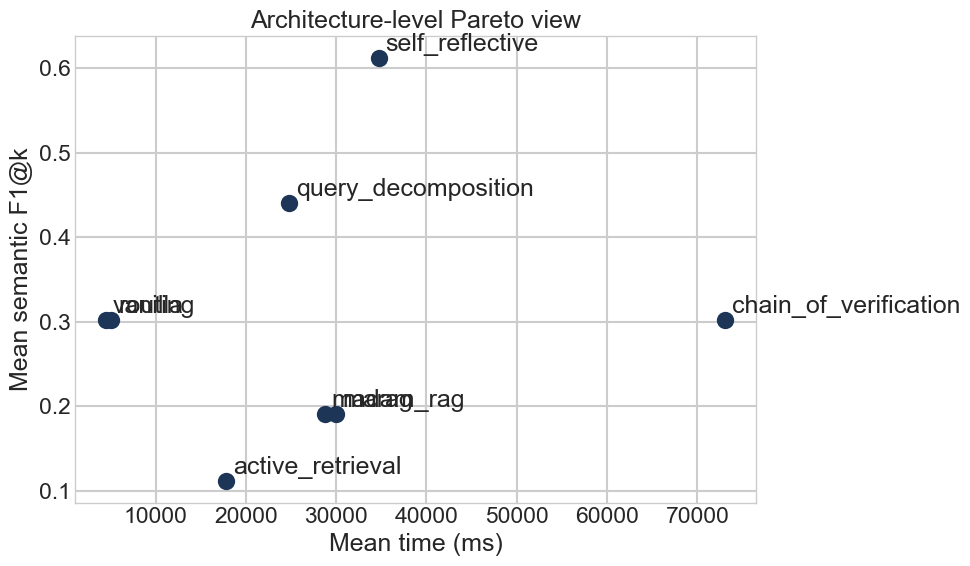

In [110]:
rel = sns.relplot(
    data=analysis_df,
    x='time_ms',
    y='semantic_f1_k',
    col='architecture',
    col_wrap=3,
    kind='scatter',
    height=4,
    hue='architecture',
    palette='tab10',
    facet_kws={'sharex': False, 'sharey': False},
)
rel.set_titles(col_template='{col_name}')
plt.tight_layout()

arch_level = analysis_df.groupby('architecture').agg(
    time_ms_mean=('time_ms', 'mean'),
    semantic_f1_k_mean=('semantic_f1_k', 'mean'),
)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(arch_level['time_ms_mean'], arch_level['semantic_f1_k_mean'], s=120, color='#1d3557')
for arch, row in arch_level.iterrows():
    ax.annotate(arch, (row['time_ms_mean'], row['semantic_f1_k_mean']), textcoords='offset points', xytext=(5,5))
ax.set_title('Architecture-level Pareto view')
ax.set_xlabel('Mean time (ms)')
ax.set_ylabel('Mean semantic F1@k')
plt.tight_layout()



## 6. Keyword vs semantic metrics analysis
Investigate relationships between lexical and semantic scoring.


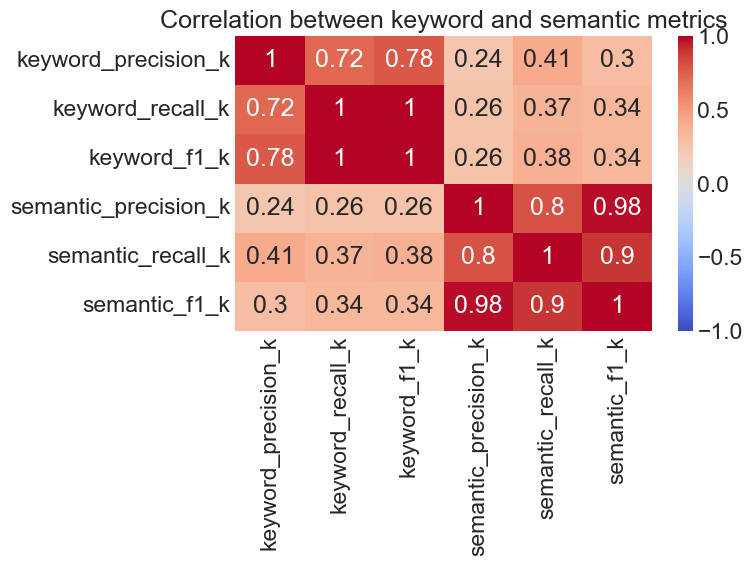

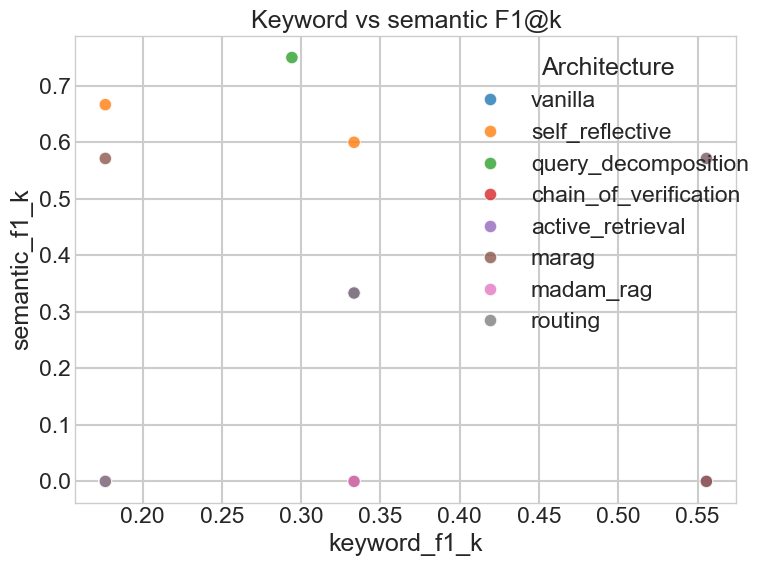

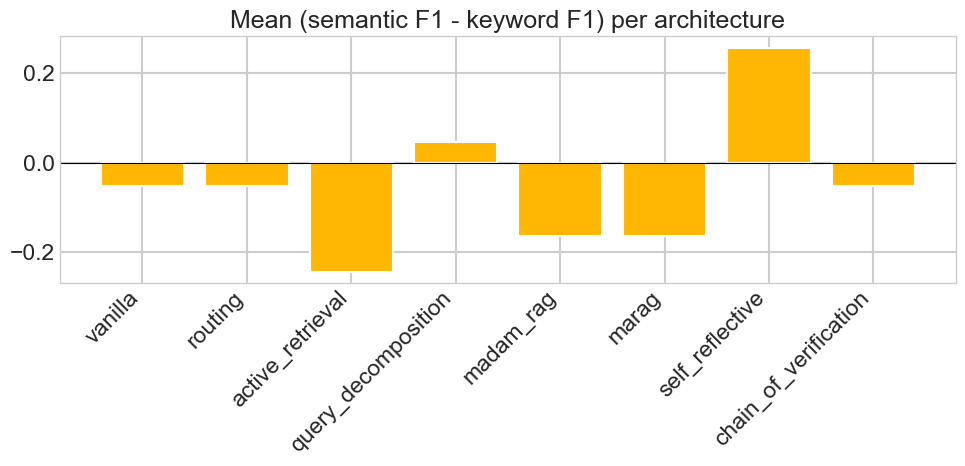

In [117]:
metric_cols = [
    'keyword_precision_k', 'keyword_recall_k', 'keyword_f1_k',
    'semantic_precision_k', 'semantic_recall_k', 'semantic_f1_k'
]
metric_corr = analysis_df[metric_cols].corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(metric_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation between keyword and semantic metrics')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=analysis_df,
    x='keyword_f1_k',
    y='semantic_f1_k',
    hue='architecture',
    palette='tab10',
    alpha=0.8,
    ax=ax,
)
ax.set_title('Keyword vs semantic F1@k')
plt.legend(title='Architecture', bbox_to_anchor=(1.05, 1), loc='upper right')
plt.tight_layout()

f1_diff = arch_summary['semantic_f1_k_mean'] - arch_summary['keyword_f1_k_mean']
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(plot_order))
ax.bar(x, f1_diff.loc[plot_order], color='#ffb703')
ax.set_title('Mean (semantic F1 - keyword F1) per architecture')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels(plot_order, rotation=45, ha='right')
plt.tight_layout()



## 7. Grounding score analysis
Inspect grounding consistency where available.


,mean,median,std
architecture,,,
active_retrieval,0.763533,0.846154,0.286845
chain_of_verification,0.527459,0.521739,0.020295
madam_rag,0.430556,0.375000,0.295608
marag,0.800427,0.884615,0.189580
query_decomposition,0.743990,0.774194,0.055446
routing,0.857143,0.928571,0.188982
self_reflective,0.834300,0.805195,0.078036
vanilla,0.853480,0.846154,0.142998


Correlation between grounding score and semantic F1: 0.088


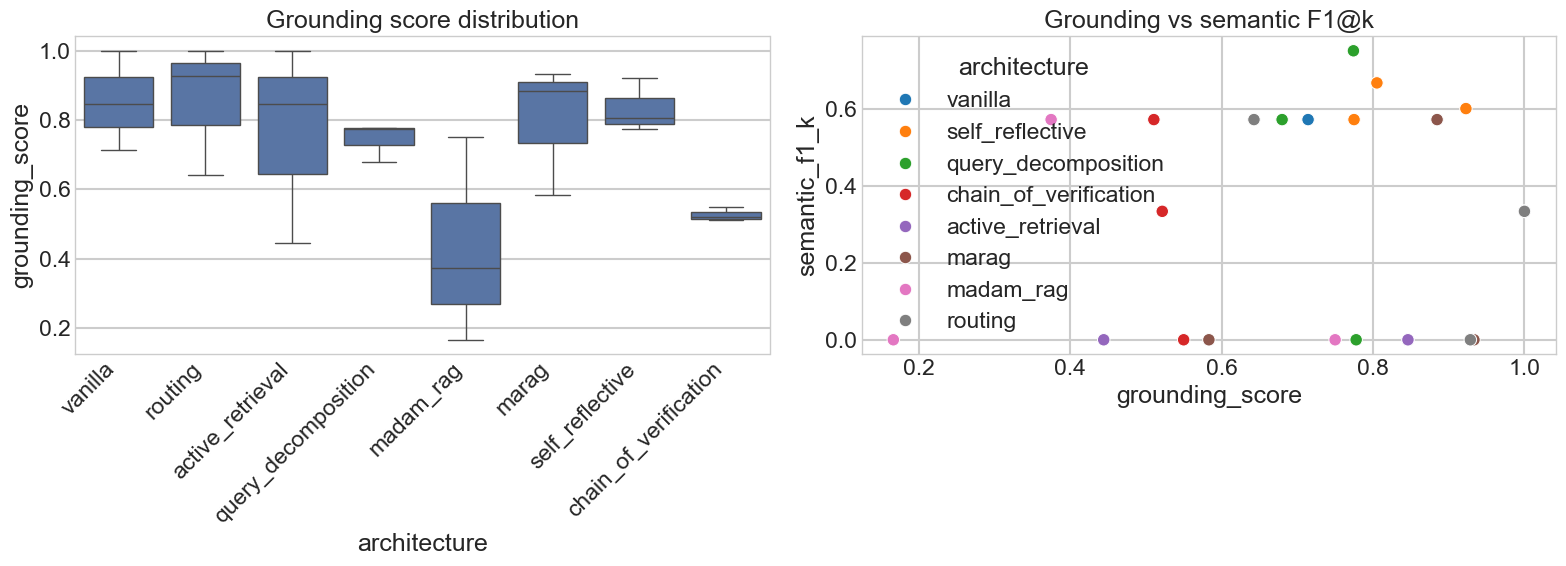

In [112]:
if analysis_df['grounding_score'].notna().any():
    ground_df = analysis_df.dropna(subset=['grounding_score'])
    ground_summary = ground_df.groupby('architecture')['grounding_score'].agg(['mean', 'median', 'std'])
    display(ground_summary)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.boxplot(data=ground_df, x='architecture', y='grounding_score', order=plot_order, ax=axes[0])
    axes[0].set_title('Grounding score distribution')
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    sns.scatterplot(
        data=ground_df,
        x='grounding_score',
        y='semantic_f1_k',
        hue='architecture',
        palette='tab10',
        ax=axes[1],
    )
    axes[1].set_title('Grounding vs semantic F1@k')
    plt.tight_layout()

    corr_val = ground_df['grounding_score'].corr(ground_df['semantic_f1_k'])
    print(f"Correlation between grounding score and semantic F1: {corr_val:.3f}")
else:
    print('Grounding scores are unavailable for these runs.')



## 8. Routing architecture behavior
Deep dive into routing choices, accuracy, and effectiveness.


Routing pipeline counts:
routing_pipeline
vanilla    3
Name: count, dtype: int64
Routing profile counts:
routing_profile
balanced_openai    3
Name: count, dtype: int64


,mean_semantic,mean_time,count
routing_pipeline,,,
vanilla,0.301587,5110.523433,3


Routing matches the best architecture on 33.3% of questions.
Average semantic gap vs best: 0.3389; vs vanilla: 0.0000
Routing pipeline decision equals best-performing architecture in 33.3% of cases.


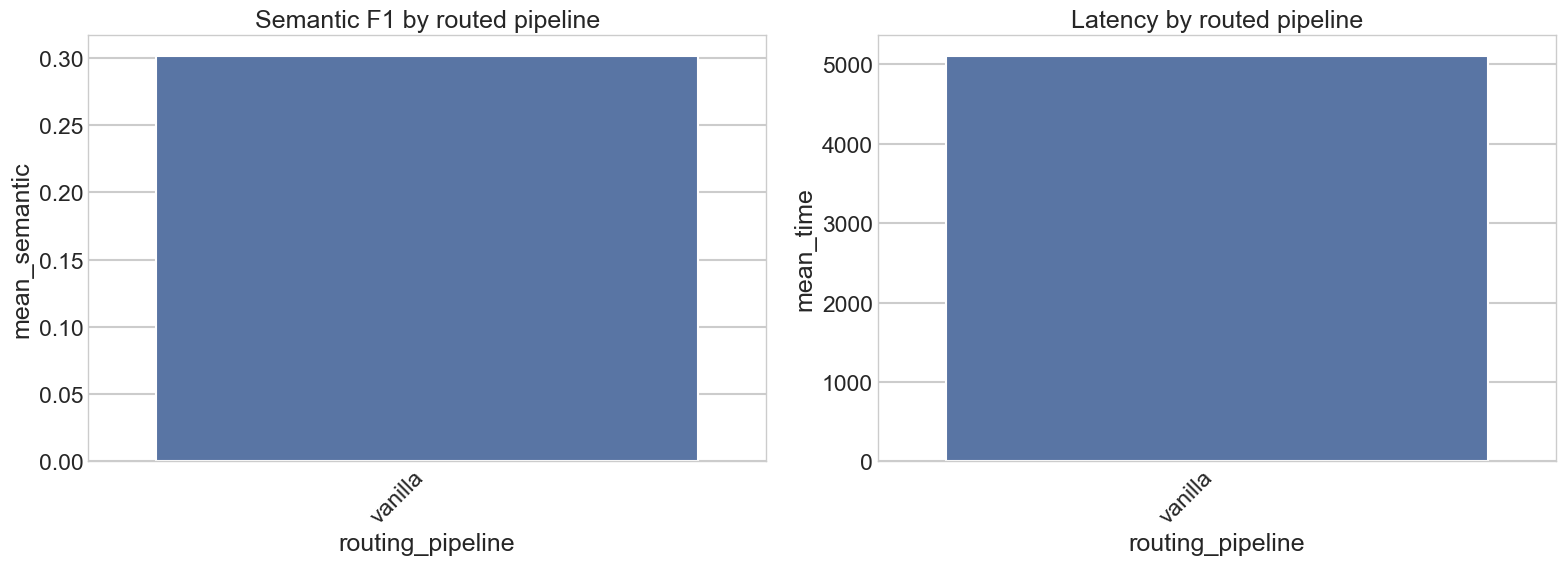

In [118]:
routing_df = analysis_df[analysis_df['architecture'] == 'routing'].copy()
if routing_df.empty:
    print('Routing architecture data not present in this experiment set.')
else:
    routing_df['routing_pipeline'] = routing_df['routing_pipeline'].fillna('unknown')
    routing_df['routing_profile'] = routing_df['routing_profile'].fillna('unknown')
    print('Routing pipeline counts:')
    print(routing_df['routing_pipeline'].value_counts())
    print('Routing profile counts:')
    print(routing_df['routing_profile'].value_counts())

    pipeline_perf = routing_df.groupby('routing_pipeline').agg(
        mean_semantic=('semantic_f1_k', 'mean'),
        mean_time=('time_ms', 'mean'),
        count=('question_id', 'count'),
    ).sort_values('mean_semantic', ascending=False)
    display(pipeline_perf)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.barplot(
        data=pipeline_perf.reset_index(),
        x='routing_pipeline',
        y='mean_semantic',
        ax=axes[0],
    )
    axes[0].set_title('Semantic F1 by routed pipeline')
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    sns.barplot(
        data=pipeline_perf.reset_index(),
        x='routing_pipeline',
        y='mean_time',
        ax=axes[1],
    )
    axes[1].set_title('Latency by routed pipeline')
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()

    best_per_question = analysis_df.groupby('question_id')['semantic_f1_k'].max().rename('best_semantic')
    routing_df = routing_df.merge(best_per_question, on='question_id', how='left')
    routing_df['gap_to_best'] = routing_df['best_semantic'] - routing_df['semantic_f1_k']

    vanilla_df = analysis_df[analysis_df['architecture'] == 'vanilla'][['question_id', 'semantic_f1_k']]
    vanilla_df = vanilla_df.rename(columns={'semantic_f1_k': 'vanilla_semantic'})
    routing_df = routing_df.merge(vanilla_df, on='question_id', how='left')
    routing_df['gap_to_vanilla'] = routing_df['vanilla_semantic'] - routing_df['semantic_f1_k']

    routing_accuracy = (routing_df['gap_to_best'].abs() < 1e-9).mean()
    print(f"Routing matches the best architecture on {routing_accuracy * 100:.1f}% of questions.")
    print(
        f"Average semantic gap vs best: {routing_df['gap_to_best'].mean():.4f}; vs vanilla: {routing_df['gap_to_vanilla'].mean():.4f}"
    )

    max_mask = (
        analysis_df['semantic_f1_k']
        == analysis_df.groupby('question_id')['semantic_f1_k'].transform('max')
    )
    best_arch_per_question = (
        analysis_df.loc[max_mask, ['question_id', 'architecture']]
        .groupby('question_id')['architecture']
        .agg(lambda s: set(s))
    )
    routing_df['correct_pipeline_choice'] = routing_df.apply(
        lambda row: row['routing_pipeline'] in best_arch_per_question.loc[row['question_id']], axis=1
    )
    print(
        f"Routing pipeline decision equals best-performing architecture in {routing_df['correct_pipeline_choice'].mean() * 100:.1f}% of cases."
    )



## 9. Advanced multi-metric analysis
Correlations, efficiency metrics, stability, and optional clustering of architectures.


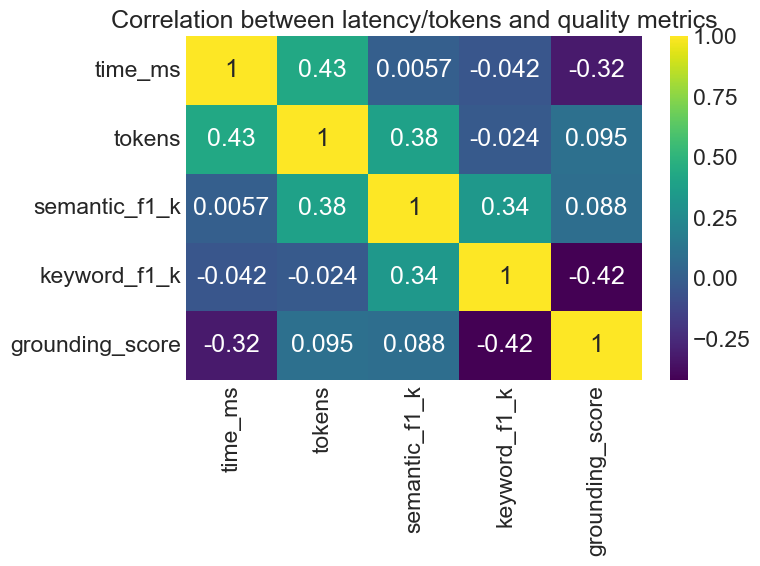

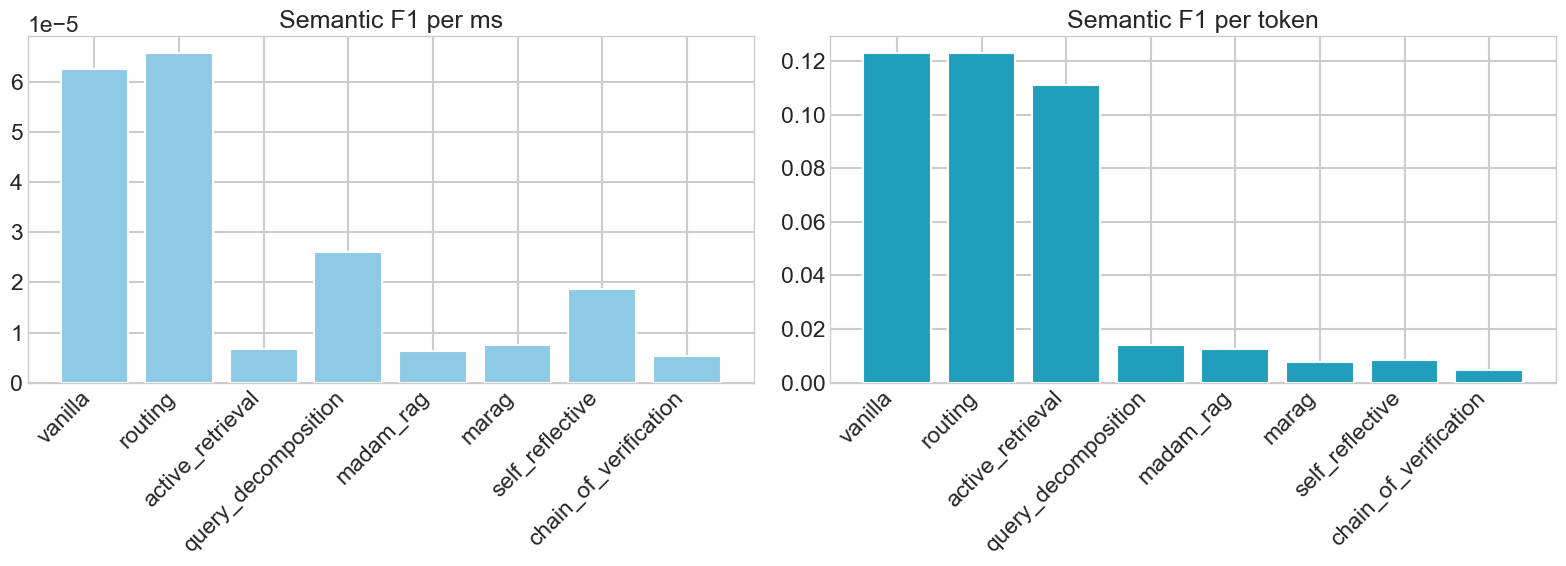

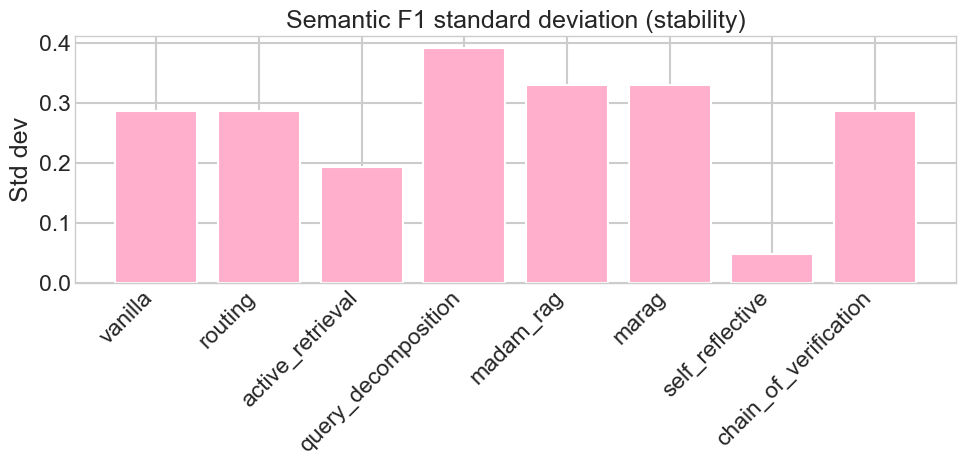

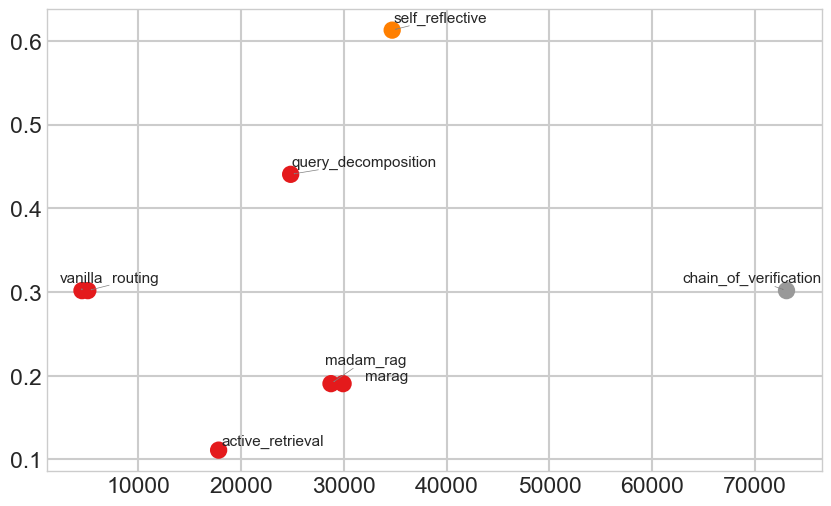

In [ ]:
advanced_metrics = analysis_df[['time_ms', 'tokens', 'semantic_f1_k', 'keyword_f1_k', 'grounding_score']]
advanced_corr = advanced_metrics.corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(advanced_corr, annot=True, cmap='viridis', ax=ax)
ax.set_title('Correlation between latency/tokens and quality metrics')
plt.tight_layout()

analysis_df['semantic_per_ms'] = analysis_df['semantic_f1_k'] / analysis_df['time_ms'].replace(0, np.nan)
analysis_df['semantic_per_token'] = analysis_df['semantic_f1_k'] / analysis_df['tokens'].replace(0, np.nan)

efficiency_summary = analysis_df.groupby('architecture').agg(
    semantic_per_ms_mean=('semantic_per_ms', 'mean'),
    semantic_per_token_mean=('semantic_per_token', 'mean'),
    semantic_std=('semantic_f1_k', 'std'),
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x = np.arange(len(plot_order))
axes[0].bar(x, efficiency_summary.loc[plot_order, 'semantic_per_ms_mean'], color='#8ecae6')
axes[0].set_title('Semantic F1 per ms')
axes[0].set_xticks(x)
axes[0].set_xticklabels(plot_order, rotation=45, ha='right')
axes[1].bar(x, efficiency_summary.loc[plot_order, 'semantic_per_token_mean'], color='#219ebc')
axes[1].set_title('Semantic F1 per token')
axes[1].set_xticks(x)
axes[1].set_xticklabels(plot_order, rotation=45, ha='right')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, efficiency_summary.loc[plot_order, 'semantic_std'], color='#ffafcc')
ax.set_title('Semantic F1 standard deviation (stability)')
ax.set_ylabel('Std dev')
ax.set_xticks(x)
ax.set_xticklabels(plot_order, rotation=45, ha='right')
plt.tight_layout()

try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from adjustText import adjust_text
    feature_cols = ['time_ms_mean', 'tokens_mean', 'semantic_f1_k_mean', 'keyword_f1_k_mean']
    cluster_df = arch_summary[feature_cols].copy()
    if cluster_df.isna().any().any():
        cluster_df = cluster_df.fillna(cluster_df.mean())
    scaler = StandardScaler()
    scaled = scaler.fit_transform(cluster_df)
    kmeans = KMeans(n_clusters=min(3, len(cluster_df)), random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(scaled)
    cluster_df['cluster'] = cluster_labels
    cluster_df['architecture'] = cluster_df.index
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(
        cluster_df['time_ms_mean'],
        cluster_df['semantic_f1_k_mean'],
        c=cluster_df['cluster'],
        cmap='Set1',
        s=120,
    )
    texts = []
    for _, row in cluster_df.iterrows():
        texts.append(
            ax.text(
                row['time_ms_mean'],
                row['semantic_f1_k_mean'],
                row['architecture'],
                fontsize=11,
                ha='left',
                va='bottom',
            )
        )

    adjust_text(
        texts,
        x=cluster_df['time_ms_mean'],
        y=cluster_df['semantic_f1_k_mean'],
        ax=ax,
        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
    )

except ImportError:
    print('one of the libraries not installed; skipping clustering analysis.')
